# Vergleich der verschiedenen Modelle




## Aufbau:
Der Beispielcode ist wie folgt aufgebaut: 
### Abschnitt 1: Datensatz vorbereiten
In diesem Abschnitt werden, wie auch bei den einzelnen Notebooks dieser Art, die notwendigen [Bibliotheken](./requirements.txt) eingebunden sowie die Daten aufbereitet. Es wird ein sogenanntes [Dictonary](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/) erstellt welches die Bilder des Datensatzes verwaltet. Ebenso werden die Bilder in diesem Abschnitt von einer Matrix in einen Vektor umgewandelt. Die Theorie dazu ist in dem logistische Regression [Use-Case](https://github.com/TW-Robotics/AIAV/tree/devel_abdank/Logistische_Regression_fuer_Bildklassifizierung) beschrieben.  

### Abschnitt 2: Erstellen der Modelle
In Abschnitt 2 werden die vier Modelle definiert welche eingesetzt werden.
Der unterschied zu den bisherigen Use-Cases ist, das ein Dictonary erstellt wird in dem die Modelle definiert werden. Das ermöglicht es anschließend mit einem "Datentyp" vier verschiedene Klassifizierungen durchzuführen. 

Zum Einsatz kommt hier die [scikit-learn](https://scikit-learn.org/stable/index.html) Bibliothek welche es ermöglicht die bereits existierendes Modelle einzubinden und nur die Parameter zu definieren. Dadurch sind features wie Skalieren, PCA oder das Trainieren leicht umgesetzt. Was eine PCA ist und welche Parameter sich auf die LR auswirken sind ebenfalls im [Storyboard](11_Storyboard_logistic_regression.pdf) zu finden. 

### Abschnitt 3: Webcam Implementierung
In diesem Abschnitt wird die Webcam eingebunden mittels [OpenCV](https://opencv.org/). Da ein Video-Stream nur aus vielen hintereinader ablaufenden Bildern besteht, wird einfach jeder Frame (jedes Bild) angeschaut und vier Mal Klassifiziert. Das Ergebnis wird direkt in die Bilder hinein geschrieben und angezeigt. 


## Ordnerstruktur: 
1. demo

    - webcam_demo.gif
    - _demo images_
    
2. Tool_Data

    - Hammer _data images_
    - Workspace _data images_
    
3. `miniUsecases13_DeepkNN.ipynb`
4. `workspace_detection_{width}x{height}px.pkl`
5. `ReadMe.md`
6. `requirements.txt`


## Resultat: 
Als Resultat wird ein Kamera-Stream ausgegeben mit vier gleichen Bildern. In jedem Bild wird das Ergebnis des jeweiligen Models eingeblendet. 

## Importieren der generellen notwendigen Bibliotheken
Wir empfehlen die notwendigen Bibliotheken über die [requirements.txt](requirements.txt) Datei zu installieren. Das ermöglicht es, dass automatisch die richtigen Versionen installiert werden. Sollte eine Library nicht vorhanden sein, dann kann die häufig auch mit `pip3 <package-name\>` nachinstalliert werden. Sind alle libraries vorhanden, entsteht kein Output bei der nächsten Zelle. 
Im laufe des Notebooks werden weitere Bibliotheken benötigt. Diese werden erst in späteren Zellen aufgerufen um jeweils bei den entsprechenden Codesnipped zu garantieren, dass sie im Workspace geladen sind.


In [1]:
# data von miniUsecase11 logistic regression 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2grey
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning) 
warnings.simplefilter('ignore',UserWarning)



## Verschiedene Einstellungen um das Programm anzupassen

data_path: gibt den relativen Pfad zu dem Datensatz (Ordner mit Bildern) an. 

os.listdir(data_path): Zeigt die Ordner an, welche die Bilder für das Trainieren enthalten sollen. 

SIZE: definiert die größe des Bildes. Hier kann eingestellt werden wie sehr das Bild "verkleinert" werden soll. Ein guter Startpunkt ist meist _<original_image_size/rescaling\>_ wobei rescaling einfach als Skalar gewählt werden kann. In dem Beispiel verwenden wir ein viertel der Pixellänge. Sprich ein 416x416 Pixelbild ist dann nur mehr 104x104px groß 

In [2]:
# Hier den Pfad und Bildgröße ändern
data_path = os.getcwd() + "/Tool_Data"
os.listdir(data_path) #im falle von dem Hammer-Beispiel werden hier Hammer und Workspace angezeigt
SIZE = 416/4 

## Zusatzfunktion für das preperieren der Daten 
Diese funktion lädt alle Bilder in den Workspace (aus dem definierten Pfad) und macht foglende 2 Aktionen:
- Resize: Skaliert die Bilder entsprechend der Vorgabe
- Dictionary: Erstellt ein Dictionary mit Labels und Metadata (Datensatz für das Trainieren). Der output wird als _pickle file_ im Workspace abgespeichert.

Parameter: 
- src: gibt den Pfad zu den Daten an
- pklname: erstellt den Namen für die Pickle Datei
- include: Includiert als String List die beiden Klassen (Hammer, Workspace)
- width: gibt die größe der Bilder/Resize an

[Tutorial zu Dictionary](https://kapernikov.com/tutorial-image-classification-with-scikit-learn/)

In [3]:
# Libraries 
import joblib
from skimage.io import imread
from skimage.transform import resize


# Funktionsdefinition 
def resize_all(src, pklname, include, width = 150, height=None):
    height = height if height is not None else width #ERRORHANDLING
    
# definiert den Datansatz als Dictionary 
    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   

    pklname = f"{pklname}_{width}x{height}px.pkl"

    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
 # itteriert über alle Bilder im Datensatz 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
# erstellt die Pickle file
        joblib.dump(data, pklname)

## Formatieren des Datensatzes
Hier wird die Hilfsfunktion aufgerufen, die für das erstellen des Datensatzes notwendig ist. Ebenso werden hier die Parameter übergeben. Zu beachten ist, dass hier nur _.jpg_ und _.png_ Bilder verarbeitet werden können. 

In [4]:
base_name = 'workspace_detection'   # Name für die Beschreibung des Datensatzes
width = SIZE                        # Definierte Bildgröße übergeben (Zelle 2)
include = {'Workspace', 'Hammer'}   # Ordner angeben
 
#FUNCTION CALL
resize_all(src=data_path, pklname=base_name, width=width, include=include) # Funktionsaufruf für das erstellen der pkl-Datei 

Workspace
Hammer


## Informationen vom Datensatz
anbei werden bei korrektem erstellen des Dictionarys die Informationen dazu angezeigt. Diese werden über die Pickle Datei ausgelesen

In [5]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')    # Laden der Datei
print('Anzahl der gefundenen Daten: ', len(data['data']))   
print('keys: ', list(data.keys()))                          # Zeigt die einzelnen Komponenten  
print('Beschreibung: ', data['description'])                
print('Bild Form ', data['data'][0].shape)                  # Format anzeigen. Nützlich für das Reshapen nachher
print('Labels:', np.unique(data['label']))                  # Labels für die Klassifizierung
Counter(data['label'])                                      # Aufteilung anzeigen

Anzahl der gefundenen Daten:  954
keys:  ['description', 'label', 'filename', 'data']
Beschreibung:  resized (104x104) images in rgb
Bild Form  (104, 104, 3)
Labels: ['Ha' 'Works']


Counter({'Works': 322, 'Ha': 632})

## Datensatz Beispiel der beiden Klassen
Folgende Zelle lädt jeweils ein Bild/Klasse. Sollten hier nicht erwartete Bilder erscheinen muss der Datensatz überprüft werden.

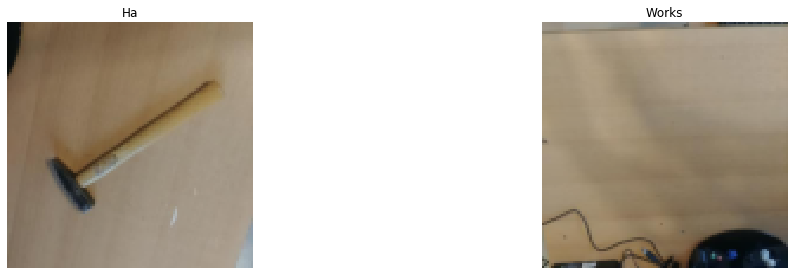

In [6]:
labels = np.unique(data['label'])           # Labels auslesen


# Matplot handling um Achsen zu erstellen
fig, axes = plt.subplots(1, len(labels))    # Plot definieren
fig.set_size_inches(15,4)                   # Größe
fig.tight_layout() 

# Generiert einen Plot mit einem Bild aus jeder Klasse
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

## Datensatz umformen
Die derzeitige Form eines eingelesenen Bildes ist <index, breite, höhe, schichten> mit index für die Anzahl der Elemente, Breite/Höhe gibt die Bildgröße in Pixel an und Schichten beschreibt die Art des Bildes (3 = RGB)

Um eine Klassifikation durchzuführen benötigt das System einen Vektor mit maximal 2 Dimensionen. Wir wollen einen Vektor mit <index, pixel_vektor>, wobei index gleich bleibt um mit den Labels (y-Vektor) übereinzustimmen. Der pixel_vektor ("Daten" entsprechend zum Index im X-Vektor) wird aus den restlichen Ebenen gebildet, um einen 1*n Vektor zu erhalten.  



In [7]:
X = np.array(data['data'])                                      # Einlesen der Bilder
print("Original Form: {}".format(X.shape))                      
x = X.reshape(X.shape[0], X.shape[1]* X.shape[2]* X.shape[3])   # Umformen auf die beschriebene Größe
print("Umgeformter Datensatz der Form: {}".format(x.shape))

y = np.array(data['label'])                                     # Einlesen der Labels
print("Der Index muss mit der Labels größe Übereinstimmen. \nLabels größe: {}".format(y.shape)) #Abgleichen ob die Form übereinstimmt 

Original Form: (954, 104, 104, 3)
Umgeformter Datensatz der Form: (954, 32448)
Der Index muss mit der Labels größe Übereinstimmen. 
Labels größe: (954,)


# Abschnitt 2: Erstellen der Modelle

## Grundaufbau
(1)Datensatz aufteilen: Hier wird der Datensatz in einen Trainingsanteil und in einen Testanteil Aufgeteilt um zu überprüfen ob das Model in die richtige Richtung trainiert
(2)Skalieren: Standardisierung von Merkmalen durch Entfernen des Mittelwerts und Skalierung auf Einheitsvarianz
(3)PCA: Principal component analysis für eine lineare Dimensionalitätsreduktion des Eingangsvektors. ("Pixelreduktion" unserer Trainingsdaten)
(4)Model definieren


## Modelle
| Model | Storyboard link | GitHub link | sklearn Dokumentation | 
|---|---|---|---|
| logistische Regression | [Storyboard](http://www.aiav.technikum-wien.at/) | [GitHub](https://github.com/TW-Robotics/AIAV/tree/devel_abdank/Logistische_Regression_fuer_Bildklassifizierung) | [Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) |  
| Support Vector Machine | [Storyboard](http://www.aiav.technikum-wien.at/) | [GitHub](https://github.com/TW-Robotics/AIAV/tree/devel_abdank/Support_Vector_Machine_fuer_Bildklassifizierung) | [Dokumentation](https://scikit-learn.org/stable/modules/svm.html) |
| k-Neares Neighbour | [Storyboard](http://www.aiav.technikum-wien.at/) | [GitHub](https://github.com/TW-Robotics/AIAV/tree/devel_abdank/kNearest_Neighbor_fuer_Bildklassifizierung) | [Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) |
| Random Forest | [Storyboard](http://www.aiav.technikum-wien.at/) | [GitHub](https://github.com/TW-Robotics/AIAV/tree/devel_abdank/Random_Forest_fuer_Bildklassifizierung) | [Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) | 




Zum Einsatz kommt hier die sklearn Bibliothek welche ermöglicht ein bereits existierendes Model einzubinden und nur die Parameter zu definieren. Dadurch sind features wie Skalieren, PCA oder das Trainieren leicht umgesetzt. 


### Aufteilen und Transformieren (PCA)
#### (1) Datensatz Teilen
Im ersten Abschnitt der folgenden Zelle wird der Datensatz in Trainings und Test Daten aufgeteilt. Das ermöglicht das trainieren und das anschließende testen des Models 

#### (2)&(3) Principal Component Analysis (PCA)
Im zweiten Teil wird eine PCA auf den Datensatz angewandt. Dies ermöglicht, dass nicht alle Pixel als Trainingsdaten herangezogen werden sonder nur herausstechende Features. 


In [8]:
# Aufteilen des Datensatzes (1)
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=.25,
                                                    random_state=1234123)


# (2) Skalieren
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#  PCA (3)
pca = PCA(.95)                                  # verwendet 95% der Komponenten und erstellen der "PCA-Instanz"
pca.fit(X_train)                                # PCA aufgrund von Datensatz auslegen
pca.n_components_                               
X_train = pca.transform(X_train)                # PCA auf Datensatz anwenden
X_test = pca.transform(X_test)                  # PCA auf Test Daten anwenden
pd.Series(y_train).value_counts()               # Evaluieren der Verteilung der Daten

Ha       475
Works    240
dtype: int64

#### (4) Modell definieren
In der folgenden Zelle werden die vier angesprochenen Modelle definiert. Es wird ein Dictionary angelegt um anschlißend über den definierten Classifier das gewünschte Modell auszuwählen. 
Hier können auch alle Parameter getuned werden, welche für die einzelnen Modelle verwednet werden. 

Genaue Informationen zu den einzelnen Modellen sind in den entsprechenden Use-Cases zu finden. Die Parameter sind ebenfalls auch in der sklearn Dolumentation beschrieben: 
| Model                  | Informationen |
|---                     |---|
| logistische Regression | [Parameter](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) | 
| SVM                    | [Parameter](https://scikit-learn.org/stable/modules/svm.html) |
| k-NN                   | [Parameter](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) |
| Random Forest          | [Parameter](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) |

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Define all Classifiers
CLASSIFIERS = {
    "Logistic Regression": LogisticRegression(solver='saga', C=0.5, multi_class='ovr',random_state=0, max_iter=10000),
    "SVM" : SVC(kernel='linear', probability=True, random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=3),
    "Random Forest" : RandomForestClassifier(max_depth=5, random_state=0, n_estimators = 10),
}

In [10]:
print("+----------------------------------------+")
print("           Model accuracy")


for name, classifier in CLASSIFIERS.items():
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)               # Auswertung
    print('  {}: {:%}'.format(name,accuracy))               # Ausgabe der Genauigkeit


print("\n+----------------------------------------+")


+----------------------------------------+
           Model accuracy
  Logistic Regression: 91.631799%
  SVM: 94.142259%
  k-NN: 90.376569%
  Random Forest: 91.213389%

+----------------------------------------+


# Abschnitt 3: Webcam Implementierung
## Ausführung der Live erkennung
In der folgenden Zelle wird ein Kamerastream geöffnet und Frame für Frame eine Prediction durchgeführt. so wie es in dem Demo example auch passiert ist. Der unterschied hier ist lediglich, dass die Bilder nicht eingelesen werden über vorhandene Daten sondern dynamisch über die Kamera "generiert" werden.  


## Demo Zelle für das Ausführen der Prediction für 2 Bilder
Die folgende Zelle nimmt nun das trainierte Modell her und führt eine Prediction anhand zwei demo Bilder durch. Diese sind in dem Demo Ordner hinterlegt. Ziel ist es einmal einen Workspace und einmal einen Hammer zu erkennen. Ist dies nicht der Fall, ist es wahrscheinlich keine gute Vorraussetzung für die Webcam-Implementation und die Modell-Parameter sollten überarbeitet werden. 

In [11]:

# Einlesen und definieren der Bilder
demo1 = "demo/Demo_001.jpeg" #Hammer
demo2 = "demo/Demo_002.jpeg" #Workspace
width = SIZE
height = SIZE

# Vorbereiten der Bilder
im1 = imread(demo1)
im1 = resize(im1, (width, height))
im1 = im1.reshape(1 ,-1)
im1 = scaler.transform(im1)
im1 = pca.transform(im1)

# Vorbereiten der Bilder
im2 = imread(demo2)
im2 = resize(im2, (width, height))
im2 = im2.reshape(1 ,-1)
im2 = scaler.transform(im2)
im2 = pca.transform(im2)




for name, classifier in CLASSIFIERS.items():
    # Prediction und Ausgabe für das erste Bild
    y_new_prob  = classifier.predict_proba(im1)
    y_new  = classifier.predict(im1)
    print("Hammer Example with {}:".format(name))
    print("Class: {}\t with Probability of: \t{} ".format(y_new[0], y_new_prob[0]))

    # Prediction und Ausgabe für das erste Bild
    y_new_prob  = classifier.predict_proba(im2)
    y_new  = classifier.predict(im2)
    print("Workspace Example with {}:".format(name))
    print("Class: {}\t with Probability of: \t{} \n".format(y_new[0], y_new_prob[0]))
    


Hammer Example with Logistic Regression:
Class: Ha	 with Probability of: 	[9.99823653e-01 1.76346911e-04] 
Workspace Example with Logistic Regression:
Class: Works	 with Probability of: 	[1.27720651e-08 9.99999987e-01] 

Hammer Example with SVM:
Class: Ha	 with Probability of: 	[0.99545796 0.00454204] 
Workspace Example with SVM:
Class: Ha	 with Probability of: 	[0.9869431 0.0130569] 

Hammer Example with k-NN:
Class: Ha	 with Probability of: 	[1. 0.] 
Workspace Example with k-NN:
Class: Ha	 with Probability of: 	[1. 0.] 

Hammer Example with Random Forest:
Class: Ha	 with Probability of: 	[0.65188551 0.34811449] 
Workspace Example with Random Forest:
Class: Ha	 with Probability of: 	[0.64339375 0.35660625] 



Hilfsfuntkion: Setzt mit den Ankerpunkten die jeweilige Beschriftung in das fertige Bild. Beschriftet wird das angewendete Model und das Ergebnis der Klassifizierung

In [12]:
def add_label(image, name, y_new, prob, itterator):
    #Text Einstellungen
    #links oben
    loc_1_0 = (10, 40)  
    loc_1_1 = (10, 80)  
    loc_1_2 = (10, 120) 
    #rechts oben
    loc_2_0 = (426, 40) 
    loc_2_1 = (426, 80) 
    loc_2_2 = (426, 120)
    #links unten
    loc_3_0 = (10, 456) 
    loc_3_1 = (10, 496) 
    loc_3_2 = (10, 536) 
    #rechts unten 
    loc_4_0 = (426, 456) 
    loc_4_1 = (426, 496) 
    loc_4_2 = (426, 536) 
    #Font Einstellungen
    font_size = 2
    thickness = 2
    font_color = (50,50,50)
    font_color1 = (0,0,202)
    font_color2 = (124,252,0)
    
    #Beschriftung entsprechend Itterator setzen (Itterator = Model)
    if(itterator == 1):
        loc_0 = loc_1_0
        loc_1 = loc_1_1
        loc_2 = loc_1_2
    elif(itterator == 2):
        loc_0 = loc_2_0
        loc_1 = loc_2_1
        loc_2 = loc_2_2
    elif(itterator == 3):
        loc_0 = loc_3_0
        loc_1 = loc_3_1
        loc_2 = loc_3_2
    else:
        loc_0 = loc_4_0
        loc_1 = loc_4_1
        loc_2 = loc_4_2
    

    #Text wird an korrekte Stelle notiert
    cv2.putText(image, name,      loc_0, 1, font_size, font_color, thickness)
    #Auswertung für die Darstellung
    if (y_new == "Ha"):
        cv2.putText(image, "Hammer in Worspace",      loc_1, 1, font_size, font_color1, thickness)
        cv2.putText(image, "{:.2f}%".format(prob[0]), loc_2, 1, font_size, font_color1, thickness)
    elif (y_new == "Works"): 
        cv2.putText(image, "No Tool in Workspace",    loc_1, 1, font_size, font_color2, thickness)    
        cv2.putText(image, "{:.2f}%".format(prob[1]), loc_2, 1, font_size, font_color2, thickness)
    else:
        cv2.putText(image, "Unknown Class: ({})".format(y_new), (10, 40), 1, 3, (0,0,255), 2)

    # Fertiges Bild zurück geben 
    return image


    

### Webcam Klassifizerung
In der nachfolgenden Zelle wird die Webcam Klassifizerung durchgeführt. Solange ein Kamerastream erkannt wird oder der User nicht "q" (für Quit) drückt wird ein Frame aus dem Videostream genommen, umgeformt, skaliert, die PCA wird durchgeführt und anschließend vier mal Klassifiziert. Das Ergebnis ist dann im Output-Window zu sehen 

In [15]:
#libraries
from skimage.transform import resize
from sklearn.decomposition import PCA
import cv2
import numpy as np


#übernahme von parametern
device_number = -1
width = SIZE
height = SIZE

# öffnen des Video Streams
cap = cv2.VideoCapture(device_number)

while(True):
    if not (cap.isOpened()):
        print("Webcam/Kamera konnte nicht gefunden und geöffnet werden. Überprüfen Sie die Verbindung sowie die device_number")
        break
    else:
            
        # frame-by-frame Bild über dem Kamera Stream einlesen    
        ret, frame = cap.read()    
        # Beschränkungen des Streams (416x416 Bild erstellen)
        y = 50
        x = 100
        h = 416
        w = 416
        frame = frame[y:y+h, x:x+w]
        image = resize(frame, (width, height))
        image = cv2.flip(image, 0)

        # Bild aus einer Matrix in einen Vektor umformen 
        image = image.reshape(1 ,-1)
        image = scaler.transform(image)
        image = pca.transform(image)


        comb_1 = cv2.vconcat([frame, frame])
        comb_2 = cv2.vconcat([frame, frame])
        final = cv2.hconcat([comb_1, comb_2]) 
        
        # Klassifizierung mittels Logistischer Regression
        y_new_prob  = CLASSIFIERS["Logistic Regression"].predict_proba(image)
        y_new  = CLASSIFIERS["Logistic Regression"].predict(image)
        prob = y_new_prob[0]*100
        final = add_label(final, "Logistic Regression", y_new, prob, 1)
        
        # Klassifizierung mittels SVM
        y_new_prob  = CLASSIFIERS["SVM"].predict_proba(image)
        y_new  = CLASSIFIERS["SVM"].predict(image)
        prob = y_new_prob[0]*100
        final = add_label(final, "SVM", y_new, prob, 2)

        # Klassifizierung mittels k-NN
        y_new_prob  = CLASSIFIERS["k-NN"].predict_proba(image)
        y_new  = CLASSIFIERS["k-NN"].predict(image)
        prob = y_new_prob[0]*100
        final = add_label(final, "k-NN", y_new, prob, 3)

        # Klassifizierung mittels Random Forest
        y_new_prob  = CLASSIFIERS["Random Forest"].predict_proba(image)
        y_new  = CLASSIFIERS["Random Forest"].predict(image)
        prob = y_new_prob[0]*100
        final = add_label(final, "Random Forest", y_new, prob, 4)

        #Ausgabe 
        
        cv2.imshow('Prediction 2| press q to exit', final)
        #User Input für das beenden des Darstellen  
        if cv2.waitKey(1) & 0xFF == ord('q'):    
            break


# Stream schließen und Window Handling
cap.release()
cv2.destroyAllWindows()